In [1]:
%pylab inline
import calin.calib.spe_fit
import calin.math.histogram
import calin.math.optimizer
import calin.math.pdf_1d

Populating the interactive namespace from numpy and matplotlib


## Load data and plot histogram

In [2]:
fernandez_data = loadtxt('../../calib/fernandez_dc_1.5kV_6.45V.dat');
mes_hist = calin.math.histogram.SimpleHist(1.0)
mes_hist.insert_vec(fernandez_data);

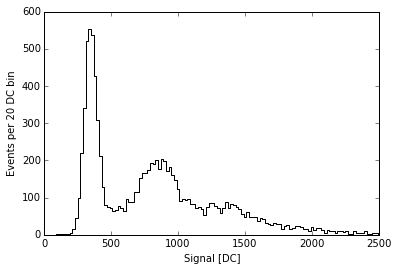

In [13]:
mes_hist_plot = calin.math.histogram.SimpleHist(20.0)
mes_hist_plot.insert_vec(fernandez_data);

ihist = range(0,mes_hist_plot.nbin());
xhist_plot = list(map(lambda i: mes_hist_plot.xval_center(i),ihist))
yhist_plot = list(map(lambda i: mes_hist_plot.weight(i),ihist))
step(xhist_plot,yhist_plot,'k')
xlabel('Signal [DC]')
ylabel('Events per 20 DC bin')
axis([0,2500,0,600])
gcf().savefig('../../../mybuild/fernandez_data.pdf')

## Fit of single-Gaussian model

In [4]:
ped_gauss_pdf = calin.math.pdf_1d.GaussianPDF()

In [5]:
ses_g_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
mes_model_g = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_g_pdf, ped_gauss_pdf)
like_g = calin.calib.spe_fit.SPELikelihood(mes_model_g, mes_hist)
opt_g = calin.math.optimizer.NLOptOptimizer("LD_LBFGS", like_g)
opt_g.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_g.set_abs_tolerance(0.0001);
opt_g.set_initial_values([1.0, 355.0, 10.0, 500.0, 200.0]);
opt_g.set_limits_lo([0.01, 300.0, 0.1, 100.0, 10.0])
opt_g.set_limits_hi([2.0,  400.0, 100.1, 1000.0, 500.0])
status, xopt_g, fval_g = opt_g.minimize()
print(status, xopt_g, fval_g)
status, err_mat_g = opt_g.calc_error_matrix()
xerr_g = sqrt(err_mat_g.diagonal())
print(xerr_g)

0 [   1.04990191  358.72165658   51.04687963  454.92516744  165.28480598] 72518.83149087398
[ 0.01317109  1.00096589  0.81565011  3.937259    3.9766476 ]


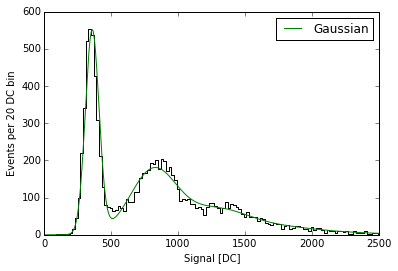

In [15]:
ihist = range(0,mes_hist_plot.nbin());
xhist_plot = list(map(lambda i: mes_hist_plot.xval_center(i),ihist))
yhist_plot = list(map(lambda i: mes_hist_plot.weight(i),ihist))
step(xhist_plot,yhist_plot,'k')

ihist = range(0,mes_hist.nbin());
xhist = list(map(lambda i: mes_hist.xval_center(i),ihist))
mes_model_g.set_parameter_values(xopt_g)
ymodel_g = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_g.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_g,'g',lw=1, label='Gaussian')
legend()
xlabel('Signal [DC]')
ylabel('Events per 20 DC bin')
axis([0,2500,0,600])
gcf().savefig('../../../mybuild/fernandez_gaussian_fit.pdf')

## Fit of exponential/Gaussian model

In [6]:
ses_eg_exp_pdf = calin.math.pdf_1d.LimitedExponentialPDF(0,numpy.inf,mes_hist.dxval())
ses_eg_exp_pdf.limit_scale(0.1, inf);
ses_eg_gauss_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_eg_pdf = calin.math.pdf_1d.TwoComponentPDF(ses_eg_exp_pdf, "exp", ses_eg_gauss_pdf, "gauss")
mes_model_eg = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_eg_pdf, ped_gauss_pdf)
like_eg = calin.calib.spe_fit.SPELikelihood(mes_model_eg, mes_hist)
opt_eg = calin.math.optimizer.NLOptOptimizer("LD_LBFGS", like_eg)
#opt_eg.set_scale([0.1,0.1,1.0,0.01,1.0,1.0,0.05]);
opt_eg.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_eg.set_abs_tolerance(0.0001);
opt_eg.set_max_iterations(1000);
opt_eg.set_initial_values([1.0, 355.0, 10.0, 0.1, 200.0, 500.0, 200.0]);
opt_eg.set_limits_lo([0.01, 300.0, 0.1, 0.0, 10.0, 100.0, 10.0])
opt_eg.set_limits_hi([2.0,  400.0, 100.1, 1.0, 500.0, 1000.0, 500.0])
status, xopt_eg, fval_eg = opt_eg.minimize()
print(status, xopt_eg, fval_eg)
status, err_mat_eg = opt_eg.calc_error_matrix()
xerr_eg = sqrt(err_mat_eg.diagonal())
print(xerr_eg)

0 [  1.21958383e+00   3.51232214e+02   4.64338310e+01   3.15225185e-01
   1.96041860e+02   4.92991929e+02   1.21171345e+02] 72466.89689786671
[  2.64560705e-02   1.25234470e+00   8.48859901e-01   3.37910425e-02
   3.71090587e+01   3.94204839e+00   5.33874632e+00]


## Fit of double-Gaussian model

Mean of one of the Gaussians is fixed at zero in the fit

In [7]:
ses_2g_g1_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_2g_g2_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_2g_pdf = calin.math.pdf_1d.TwoComponentPDF(ses_2g_g1_pdf, "g1", ses_2g_g2_pdf, "g2")
mes_model_2g = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_2g_pdf, ped_gauss_pdf)
like_2g = calin.calib.spe_fit.SPELikelihood(mes_model_2g, mes_hist)
freezer = calin.math.function.FreezeThawFunction(like_2g)
freezer.freeze(4,0)
opt_2g = calin.math.optimizer.NLOptOptimizer("LD_LBFGS", freezer)
#opt_2g.set_scale([0.1,0.1,1.0,0.01,1.0,1.0,0.05]);
opt_2g.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_2g.set_abs_tolerance(0.0001);
opt_2g.set_initial_values([1.0, 355.0, 10.0, 0.1, 200.0, 500.0, 200.0]);
status, xopt_2g, fval_2g = opt_2g.minimize()
print(status, xopt_2g, fval_2g)
status, err_mat_2g = opt_2g.calc_error_matrix()
xerr_2g = sqrt(err_mat_2g.diagonal())
print(xerr_2g)

0 [  1.18930676e+00   3.52214093e+02   4.68817800e+01   2.55606341e-01
   1.97934671e+02   4.94651876e+02   1.22595480e+02] 72465.71922122368
[  2.28579177e-02   1.23423115e+00   8.53107374e-01   3.75734366e-02
   4.83984011e+01   7.41959439e+00   5.75787437e+00]


## Draw MES and SES plots

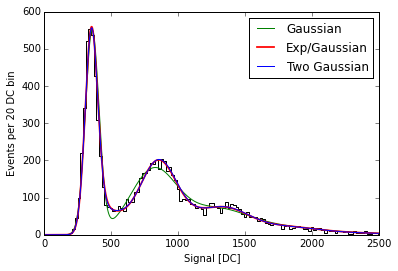

In [16]:
mes_hist_plot = calin.math.histogram.SimpleHist(20.0)
mes_hist_plot.insert_vec(fernandez_data);

ihist = range(0,mes_hist_plot.nbin());
xhist_plot = list(map(lambda i: mes_hist_plot.xval_center(i),ihist))
yhist_plot = list(map(lambda i: mes_hist_plot.weight(i),ihist))
step(xhist_plot,yhist_plot,'k')
xlabel('Signal [DC]')
ylabel('Events per 20 DC bin')

ihist = range(0,mes_hist.nbin());
xhist = list(map(lambda i: mes_hist.xval_center(i),ihist))

mes_model_g.set_parameter_values(xopt_g)
ymodel_g = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_g.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_g,'g',lw=1, label='Gaussian')

mes_model_eg.set_parameter_values(xopt_eg)
ymodel_eg = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_eg.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_eg,'r',lw=1.75, label="Exp/Gaussian")

mes_model_2g.set_parameter_values(freezer.x_in2out(xopt_2g))
ymodel_2g = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_2g.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_2g,'b',lw=1, label='Two Gaussian')

legend()
axis([0,2500,0,600])
gcf().savefig('../../../mybuild/fernandez_two_cpt_fits.pdf')

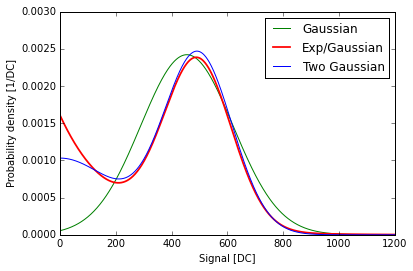

In [17]:
ses_g_y = asarray(mes_model_g.n_electron_spectrum(1));
ses_g_x = ses_g_y*0;
for i in range(0,len(ses_g_y)):
    ses_g_x[i] = mes_model_g.ses_x(i)
plot(ses_g_x, ses_g_y, 'g', label='Gaussian')

ses_eg_y = asarray(mes_model_eg.n_electron_spectrum(1));
ses_eg_x = ses_eg_y*0;
for i in range(0,len(ses_eg_y)):
    ses_eg_x[i] = mes_model_eg.ses_x(i)
plot(ses_eg_x, ses_eg_y, 'r', lw=1.75, label='Exp/Gaussian')

ses_2g_y = asarray(mes_model_2g.n_electron_spectrum(1));
ses_2g_x = ses_2g_y*0;
for i in range(0,len(ses_2g_y)):
    ses_2g_x[i] = mes_model_2g.ses_x(i)
plot(ses_2g_x, ses_2g_y, 'b', label='Two Gaussian')
legend()
axis([0,1200,0,0.003])
xlabel('Signal [DC]')
ylabel('Probability density [1/DC]')
gcf().savefig('../../../mybuild/fernandez_ses.pdf')

## Calculate gain and ENF

**Single Gaussian**

In [10]:
ses_g_norm = sum(ses_g_y)
ses_g_mean = sum(ses_g_y*ses_g_x)
ses_g_rms = sqrt(sum(ses_g_y*ses_g_x*ses_g_x) - ses_g_mean**2)
print("Norm, mean, RMS: ",ses_g_norm, ses_g_mean, ses_g_rms)
print("Resolution: ",ses_g_rms/ses_g_mean)
print("ENF: ",sqrt(1+(ses_g_rms/ses_g_mean)**2))

Norm, mean, RMS:  1.00000003804 456.422854048 163.203822418
Resolution:  0.357571539134
ENF:  1.06200631147


**Exponential/Gaussian**

In [11]:
ses_eg_norm = sum(ses_eg_y)
ses_eg_mean = sum(ses_eg_y*ses_eg_x)
ses_eg_rms = sqrt(sum(ses_eg_y*ses_eg_x*ses_eg_x) - ses_eg_mean**2)
print("Norm, mean, RMS: ",ses_eg_norm, ses_eg_mean, ses_eg_rms)
print("Resolution: ",ses_eg_rms/ses_eg_mean)
print("ENF: ",sqrt(1+(ses_eg_rms/ses_eg_mean)**2))

Norm, mean, RMS:  1.00000000063 399.394343876 202.979427915
Resolution:  0.508218083274
ENF:  1.12173331063


**Double Gaussian**

In [12]:
ses_2g_norm = sum(ses_2g_y)
ses_2g_mean = sum(ses_2g_y*ses_2g_x)
ses_2g_rms = sqrt(sum(ses_2g_y*ses_2g_x*ses_2g_x) - ses_2g_mean**2)
print("Norm, mean, RMS: ",ses_2g_norm, ses_2g_mean, ses_2g_rms)
print("Resolution: ",ses_2g_rms/ses_2g_mean)
print("ENF: ",sqrt(1+(ses_2g_rms/ses_2g_mean)**2))

Norm, mean, RMS:  1.00000000097 408.594040398 190.779759143
Resolution:  0.466917625516
ENF:  1.10363584076
